In [24]:
from typing import TypedDict, Optional, List, Callable, Dict, Any, Literal
from typing_extensions import Annotated
import os
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import MemorySaver
from youtube_transcript_api import YouTubeTranscriptApi
from langgraph.graph import StateGraph, add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
from langgraph.graph import START, END

In [25]:
load_dotenv()
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [36]:
class BlogGenState(TypedDict):
    yt_url: Optional[str]
    transcript: Optional[str]
    blog_title: Optional[str]
    blog_content: Optional[str]
    regenerate_status: Optional[str]
    message: Annotated[list[AnyMessage], add_messages]

In [42]:
class Agents:
    def __init__(self):
        self.llm = ChatGroq(model="qwen-2.5-32b")
    def generate_blog(self, state: BlogGenState) -> BlogGenState:
        """
        Generates a title and content for the blog based on the transcript.
        
        Args:
            state: The current state of the workflow
            
        Returns:
            Updated state with blog title and content
        """
        transcript = state.get("transcript")
        if transcript is None:
            video_id = state["yt_url"].split("v=")[-1].split("&")[0]
            transcript_list = YouTubeTranscriptApi.get_transcript(video_id)
            full_transcript = " ".join([entry['text'] for entry in transcript_list])
            state["transcript"] = full_transcript
        regen_status = state.get("regenerate_status")
        if regen_status == "yes":
            title_regenerate_prompt = [
                SystemMessage(content="The user has chosen to regenerate the blog title. Please provide a new title for the blog post based on the transcript. PREVIOUS INSTRUCTIONS: You are an expert in generating titles for BLOG posts based on the transcripts of YouTube videos. IMPORTANT: YOU SIMPLY ONLY CREATE TITLES FOR THE BLOG. NO EXPLANATION IS REQUIRED."),
                HumanMessage(content=f"Generate a good blog title for a video with the following transcript: {state['transcript']}")
            ]
            content_regenerate_prompt = [
                SystemMessage(content="The user has chosen to regenerate the blog content. Please provide new content for the blog post based on the transcript. PREVIOUS INSTRUCTIONS: You are an expert in generating content for BLOG posts based on the transcripts of YouTube videos. IMPORTANT: YOU SIMPLY ONLY CREATE CONTENT FOR THE BLOG. THE TITLE IS ALREADY PROVIDED. Output format: Simply output the content in markdown format with appropriate headings, paragraphs, and formatting."),
                HumanMessage(content=f"Generate blog content for the title '{state['blog_title']}' based on the following transcript: {state['transcript']}")
            ]
            regenerated_title = self.llm.invoke(title_regenerate_prompt).content.strip()
            regenerated_content = self.llm.invoke(content_regenerate_prompt).content.strip()

            return {
                "blog_title": regenerated_title,
                "blog_content": regenerated_content,
                "message": state["message"] + [
                    SystemMessage(content=f"Blog title and content regenerated on the users request.")
                ]
            }

        title_prompt = [
            SystemMessage(content="You are an expert in generating titles for BLOG posts based on the transcripts of YouTube videos. IMPORTANT: YOU SIMPLY ONLY CREATE TITLES FOR THE BLOG. NO EXPLANATION IS REQUIRED."),
            HumanMessage(content=f"Generate a good blog title for a video with the following transcript: {state['transcript']}")
        ]
        blog_title = self.llm.invoke(title_prompt).content.strip()

        content_prompt = [
            SystemMessage(content="""You are an expert in generating content for BLOG posts based on the transcripts of YouTube videos. 
            IMPORTANT: YOU SIMPLY ONLY CREATE CONTENT FOR THE BLOG. THE TITLE IS ALREADY PROVIDED. 
            Output format: Simply output the content in markdown format with appropriate headings, paragraphs, and formatting."""),
            HumanMessage(content=f"Generate blog content for the title '{blog_title}' based on the following transcript: {state['transcript']}")
        ]
        blog_content = self.llm.invoke(content_prompt).content.strip()

        return {
            "blog_title": blog_title,
            "blog_content": blog_content,
            "message": state["message"] + [
                SystemMessage(content="Transcript fetched successfully."),
                SystemMessage(content=f"Blog title generated: {blog_title}"),
                SystemMessage(content="Blog content generated successfully.")
            ]
        }
    def human_feedback(self, state: BlogGenState) -> BlogGenState:
        """Just an empty to update the feedback param"""
        return state

In [43]:
class BlogGenGraph:
    def __init__(self):
        self.agents = Agents()
    def regenerate_condition_or_not(self, state: BlogGenState) -> Literal["regenerate","end"]:
        if state["regenerate_status"] == "yes":
            return "regenerate"
        else:    
            return "end" 
    def create_graph(self):
        graph_builder = StateGraph(BlogGenState)
        graph_builder.add_node("generate_blog_with_title",self.agents.generate_blog)
        graph_builder.add_node("human_feedback",self.agents.human_feedback)
        graph_builder.add_edge("generate_blog_with_title","human_feedback")
        graph_builder.add_conditional_edges("human_feedback",self.regenerate_condition_or_not, {"regenerate": "generate_blog_with_title", "end": END})

        graph_builder.set_entry_point("generate_blog_with_title")

        memory = MemorySaver()
        graph = graph_builder.compile(checkpointer=memory, interrupt_before=["human_feedback"])
        return graph

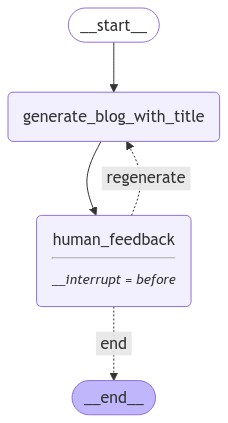

In [44]:
graph = BlogGenGraph().create_graph()
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
youtubelink = "https://www.youtube.com/watch?v=TCH_1BHY58I"
thread = {"configurable": {"thread_id": "1"}}

In [46]:
for event in graph.stream({"yt_url": youtubelink},thread, stream_mode="values"):
    print(event)

{'yt_url': 'https://www.youtube.com/watch?v=8fZRFmHyoN8&t=1433s', 'message': []}
{'yt_url': 'https://www.youtube.com/watch?v=8fZRFmHyoN8&t=1433s', 'blog_title': 'Blue Lock Reaction: Navigating the Chaos of the Top Six Trials and Finding Inspiration Amidst Confusion', 'blog_content': "## Blue Lock Reaction: Navigating the Chaos of the Top Six Trials and Finding Inspiration Amidst Confusion\n\nHey Legends, welcome back to another episode of *Blue Lock*! This season has started off very strong, and we're diving straight into the trials with the top six players to decide who makes it onto the starting squad to face the Japan under-20 team. The first match has already got me pretty frustrated. \n\nLet’s break down the first match where we see Crow (or Caro, as some call him) guarding what he thinks is the weak link, but he’s actually allowing our better players to score goals. This strategy is confusing to me, but it does force Isagi to find a way around him, which is good for our boy. \n\n

In [47]:
graph.get_state(thread).next

('human_feedback',)

In [48]:
graph.update_state(thread, {"regenerate_status": "yes"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff5e47-8e10-679f-8002-f344e89cd1f2'}}

In [49]:
for event in graph.stream(None,thread, stream_mode="values"):
    print(event)

{'yt_url': 'https://www.youtube.com/watch?v=8fZRFmHyoN8&t=1433s', 'blog_title': 'Blue Lock Reaction: Navigating the Chaos of the Top Six Trials and Finding Inspiration Amidst Confusion', 'blog_content': "## Blue Lock Reaction: Navigating the Chaos of the Top Six Trials and Finding Inspiration Amidst Confusion\n\nHey Legends, welcome back to another episode of *Blue Lock*! This season has started off very strong, and we're diving straight into the trials with the top six players to decide who makes it onto the starting squad to face the Japan under-20 team. The first match has already got me pretty frustrated. \n\nLet’s break down the first match where we see Crow (or Caro, as some call him) guarding what he thinks is the weak link, but he’s actually allowing our better players to score goals. This strategy is confusing to me, but it does force Isagi to find a way around him, which is good for our boy. \n\nThen, we have the demon, Shido, who is absolutely incredible on the field. He sco

In [50]:
graph.get_state(thread).next

('human_feedback',)

In [51]:
graph.update_state(thread, {"regenerate_status": "no"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff5e4c-f38a-67d6-8004-b9c426479fe7'}}

In [52]:
for event in graph.stream(None,thread, stream_mode="values"):
    print(event)

{'yt_url': 'https://www.youtube.com/watch?v=8fZRFmHyoN8&t=1433s', 'blog_title': 'Blue Lock Reaction: Navigating the Chaos of the Top Six Trials and Staying Motivated Through Adversity', 'blog_content': '# Blue Lock Reaction: Navigating the Chaos of the Top Six Trials and Finding Inspiration Amidst Confusion\n\nHey, Legends! Welcome back to another Blue Lock reaction. The season has started off strong, and we\'re diving right into the top six trials to see who will make it onto the starting squad to face the Japan under-20s. The first match of the trials has already got me a bit frustrated. There’s this "Crow" dude, who seems to be guarding the weak link, but his strategy doesn’t make sense to me. It\'s confusing to see him allowing better players to score goals, but at least it forces Isagi to figure out how to get around him, which is good for our boy.\n\n## The Confusion and Frustration\n\nLet\'s talk about Shido, the demon who scores an absolutely sick goal. His soundtrack and art a